In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import pandas as pd

data_path = '/kaggle/input/datasett'
files = os.listdir(data_path)
print("Files in dataset directory:", files)

# Load each CSV file (adjust extension if needed)
dfs = {}
for file in files:
    if file.endswith('.csv'):
        dfs[file] = pd.read_csv(os.path.join(data_path, file))
        print(f"\nLoaded {file} with shape: {dfs[file].shape}")

Files in dataset directory: ['combined_data_new2.dat']


In [2]:
for file, df in dfs.items():
    print(f"\nInfo for {file}:")
    print(df.info())
    print(f"\nMissing values in {file}:")
    print(df.isnull().sum())
    print(f"\nSample data from {file}:")
    print(df.head())

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

for file, df in dfs.items():
    print(f"\nSummary statistics for {file}:")
    print(df.describe())
    
    numeric_cols = df.select_dtypes(include=['number']).columns
    if len(numeric_cols) == 0:
        print(f"No numeric columns found in {file} for histogram plotting.")
        continue
    
    df[numeric_cols].hist(figsize=(12, 8))
    plt.suptitle(f'Distributions in {file}')
    plt.show()

In [4]:
for file, df in dfs.items():
    print(f"\nData types in {file}:")
    print(df.dtypes)

In [5]:
for file, df in dfs.items():
    # Try to convert all columns to numeric where possible
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    print(f"After conversion, dtypes for {file}:")
    print(df.dtypes)

In [6]:
import numpy as np
import pickle

# Load dataset (pickle .dat file with keys 'data' and 'labels')
file_path = '/kaggle/input/datasett/combined_data_new2.dat'
with open(file_path, 'rb') as f:
    data_dict = pickle.load(f)

data = data_dict['data']      # shape: (num_samples, num_channels, num_timepoints)
labels = data_dict['labels']  # shape: (num_samples,)

num_samples, num_channels, num_timepoints = data.shape

# Parameters for temporal segmentation
sampling_freq = 128        # Hz, adjust if needed
segment_seconds = 1        # segment length in seconds
segment_length = sampling_freq * segment_seconds  # number of time points per segment
step_length = segment_length   # non-overlapping segments; you can reduce for overlap

num_segments_per_sample = (num_timepoints - segment_length) // step_length + 1
total_segments = num_samples * num_segments_per_sample

print(f"Total segments expected: {total_segments}")

# 8x8 spatial mapping for 64 channels (row, col) in grid
# Fill row-wise (0,0) to (7,7) for channels 0-63
channel_map_8x8 = -1 * np.ones((8, 8), dtype=int)
chan_idx = 0
for r in range(8):
    for c in range(8):
        if chan_idx < num_channels:
            channel_map_8x8[r, c] = chan_idx
            chan_idx += 1

# Initialize arrays for spatial EEG data and labels
eeg_spatial_8x8 = np.zeros((total_segments, 8, 8, segment_length))
eeg_labels = np.zeros(total_segments, dtype=labels.dtype)

seg_idx = 0
for sample_idx in range(num_samples):
    for seg_start in range(0, num_timepoints - segment_length + 1, step_length):
        seg_end = seg_start + segment_length
        seg_matrix = np.zeros((8, 8, segment_length))
        for r in range(8):
            for c in range(8):
                ch = channel_map_8x8[r, c]
                if ch >= 0:
                    seg_matrix[r, c, :] = data[sample_idx, ch, seg_start:seg_end]
        eeg_spatial_8x8[seg_idx] = seg_matrix
        eeg_labels[seg_idx] = labels[sample_idx]
        seg_idx += 1

print(f"Segments created: {seg_idx}")

# Save spatial EEG segments and corresponding labels
np.save('eeg_spatial_8x8.npy', eeg_spatial_8x8[:seg_idx])
np.save('labels.npy', eeg_labels[:seg_idx])

print('Saved eeg_spatial_8x8.npy and labels.npy')
print('eeg_spatial_8x8 shape:', eeg_spatial_8x8[:seg_idx].shape)
print('labels shape:', eeg_labels[:seg_idx].shape)

Total segments expected: 1896
Segments created: 1896
Saved eeg_spatial_8x8.npy and labels.npy
eeg_spatial_8x8 shape: (1896, 8, 8, 128)
labels shape: (1896,)


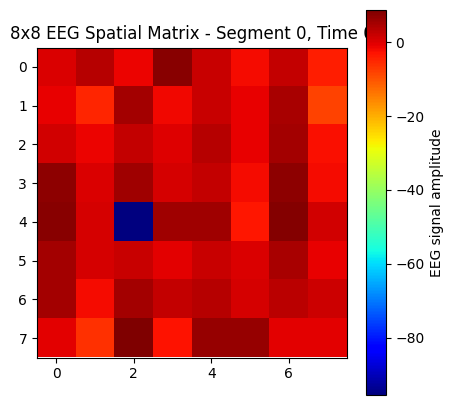

In [7]:
import matplotlib.pyplot as plt

# Load the saved spatial EEG data if needed
eeg_spatial_8x8 = np.load('eeg_spatial_8x8.npy')  # shape: (total_segments, 8, 8, segment_length)

# Select a segment and time index to visualize
segment_idx = 0    # pick the first segment or change as needed
time_idx = 0       # pick the first time point in the segment or change

# Extract the 8x8 spatial matrix at the selected time point within the segment
spatial_matrix = eeg_spatial_8x8[segment_idx, :, :, time_idx]

# Display the matrix with a colorbar
plt.figure(figsize=(5, 5))
plt.imshow(spatial_matrix, cmap='jet', interpolation='nearest')
plt.colorbar(label='EEG signal amplitude')
plt.title(f'8x8 EEG Spatial Matrix - Segment {segment_idx}, Time {time_idx}')
plt.show()

2025-10-23 20:28:25.719457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761251305.888458      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761251305.936128      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1761251633.778579      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761251633.779254      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

Epoch 1/60


I0000 00:00:1761251640.561761     107 cuda_dnn.cc:529] Loaded cuDNN version 90300



Epoch 1: val_loss improved from inf to 0.26745, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5
22/22 - 10s - 463ms/step - accuracy: 0.7852 - auc: 0.8749 - loss: 0.4424 - val_accuracy: 0.9605 - val_auc: 0.9899 - val_loss: 0.2675 - learning_rate: 0.0010
Epoch 2/60

Epoch 2: val_loss improved from 0.26745 to 0.15514, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5
22/22 - 0s - 16ms/step - accuracy: 0.9391 - auc: 0.9866 - loss: 0.1667 - val_accuracy: 0.9474 - val_auc: 0.9940 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 3/60

Epoch 3: val_loss improved from 0.15514 to 0.09425, saving model to /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_best.h5
22/22 - 0s - 16ms/step - accuracy: 0.9846 - auc: 0.9985 - loss: 0.0679 - val_accuracy: 0.9803 - val_auc: 0.9979 - val_loss: 0.0942 - learning_rate: 0.0010
Epoch 4/60

Epoch 4: val_loss improved from 0.09425 to 0.07060, saving model to /kaggle/working/hybrid_cnn_

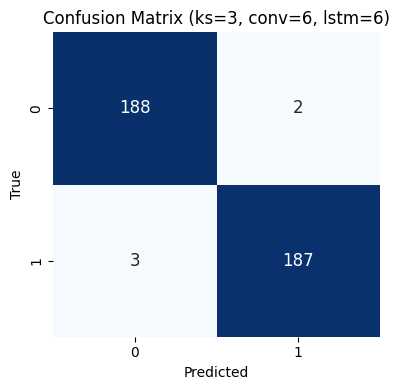

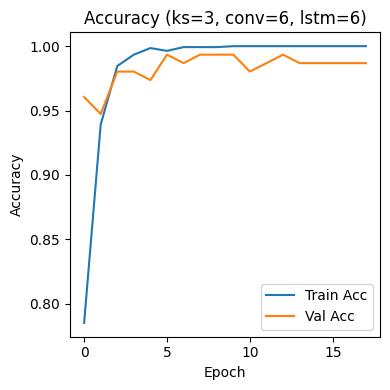

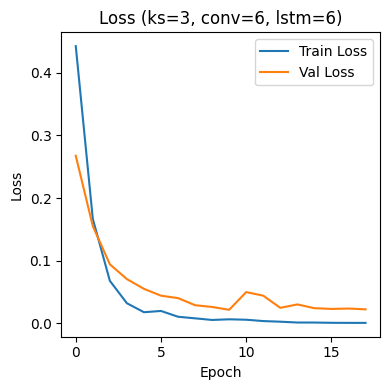

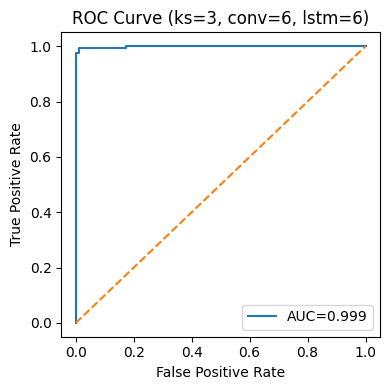

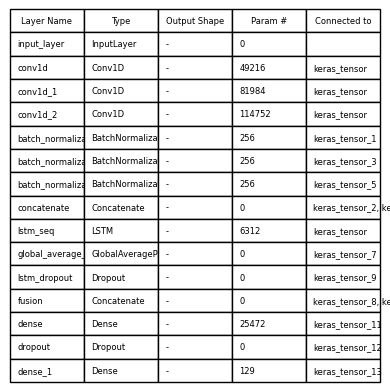


==================== FINAL RESULT ====================
Params: kernel_size=3, conv_layers=6, lstm_units=6
Accuracy:   0.9868
Sensitivity:0.9842  (Recall/TPR)
Specificity:0.9895  (TNR)
F1-score:   0.9868
Kappa:      0.9737
AUC:        0.9989
Bal.Acc:    0.9868
Confusion Matrix: TN=188, FP=2, FN=3, TP=187
Paths:
  Params CSV:  /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_params.csv
  Metrics JSON:    /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.json
  Metrics CSV:     /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_final_metrics.csv
  Report TXT:      /kaggle/working/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_classification_report.txt
  Plots (output6):
     CM:    /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_confusion_matrix_4x4.png
     ACC:   /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_accuracy_curve_4x4.png
     LOSS:  /kaggle/working/output6/hybrid_cnn_lstm_multiscale_ks3_conv6_lstm6_l

In [8]:
import os
import json
import csv
import numpy as np
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, f1_score,
                             accuracy_score, balanced_accuracy_score,
                             cohen_kappa_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models

# ------------------------- Repro & paths -------------------------------------
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTDIR = "/kaggle/working"
OUTDIR2 = "/kaggle/working/output6"   # <— plots here
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(OUTDIR2, exist_ok=True)
KERNEL_SIZE = 3
NUM_CONV_LAYERS = 6
LSTM_UNITS = 6
STAMP = f"hybrid_cnn_lstm_multiscale_ks{KERNEL_SIZE}_conv{NUM_CONV_LAYERS}_lstm{LSTM_UNITS}"

# ------------------------- Load data -----------------------------------------
# X: (samples, height, width, time_points)
X = np.load('eeg_spatial_8x8.npy')
y = np.load('labels.npy').astype(int)
fs = 128
num_samples, height, width, time_points = X.shape

# frequency bands
bands = {'delta': (1, 4), 'theta': (4, 8), 'alpha': (8, 12), 'beta': (12, 30)}
num_bands = len(bands)

# sliding windows
window_size = 64
step_size = 32
num_windows = (time_points - window_size) // step_size + 1

# ------------------------- Feature extraction --------------------------------
def bandpower(signal, fs, nperseg, low, high):
    f, psd = welch(signal, fs=fs, nperseg=nperseg)
    idx = (f >= low) & (f <= high)
    return np.trapz(psd[idx], f[idx])

X_features = np.zeros((num_samples, num_windows, height * width * num_bands), dtype=np.float32)
for i in range(num_samples):
    for w in range(num_windows):
        start, end = w * step_size, w * step_size + window_size
        feats = []
        for r in range(height):
            for c in range(width):
                seg = X[i, r, c, start:end]
                if np.any(seg):
                    for (low, high) in bands.values():
                        feats.append(bandpower(seg, fs, window_size, low, high))
                else:
                    feats.extend([0.0]*num_bands)
        X_features[i, w, :] = np.asarray(feats, dtype=np.float32)

# ------------------------- Split, then scale (no leakage) --------------------
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_features, y, test_size=0.2, random_state=SEED, stratify=y
)

scaler = StandardScaler()
Ntr, T, F = X_train_raw.shape
Nte = X_test_raw.shape[0]
X_train = scaler.fit_transform(X_train_raw.reshape(-1, F)).reshape(Ntr, T, F)
X_test = scaler.transform(X_test_raw.reshape(-1, F)).reshape(Nte, T, F)

seq_len = T
feat_dim = F  # 8*8*4 = 256

# ------------------------- Build hybrid model with Multi-Scale Feature Extraction ------------------
def build_hybrid_cnn_lstm_multiscale(seq_len, feat_dim, num_conv_layers=6, kernel_size=3, lstm_units=6):
    inp = layers.Input(shape=(seq_len, feat_dim))  # (T, F)

    # --- Multi-scale CNN branch (temporal Conv1D over windows with different kernel sizes) ---
    convs = []
    kernel_sizes = [3, 5, 7]  # Define different kernel sizes for multi-scale feature extraction
    for ks in kernel_sizes:
        x = layers.Conv1D(filters=64, kernel_size=ks, padding="same", activation="relu")(inp)
        x = layers.BatchNormalization()(x)
        convs.append(x)
        
    # Concatenate the multi-scale features (different scales of temporal patterns)
    x = layers.Concatenate()(convs)
    x = layers.GlobalAveragePooling1D()(x)  # Aggregate the multi-scale features into a single vector
    conv_embed = x

    # --- LSTM branch (temporal modeling) ---
    y = layers.LSTM(lstm_units, return_sequences=False, name="lstm_seq")(inp)  # (B, T, lstm_units)
    y = layers.Dropout(0.2, name="lstm_dropout")(y)

    # --- Fusion ---
    z = layers.Concatenate(name="fusion")([conv_embed, y])  # (B, multi-scale + lstm_units)
    z = layers.Dense(128, activation="relu")(z)
    z = layers.Dropout(0.5)(z)
    out = layers.Dense(1, activation="sigmoid")(z)

    model = models.Model(inp, out, name=f"Hybrid_CNN_LSTM_MultiScale_{STAMP}")
    model.compile(optimizer="adam",
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])
    return model

model = build_hybrid_cnn_lstm_multiscale(seq_len, feat_dim,
                              num_conv_layers=NUM_CONV_LAYERS,
                              kernel_size=KERNEL_SIZE,
                              lstm_units=LSTM_UNITS)

# ------------------------- Train ---------------------------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(OUTDIR, f"{STAMP}_best.h5"),
        monitor="val_loss", save_best_only=True, verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    epochs=60,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

# Save final model
final_model_path = os.path.join(OUTDIR, f"{STAMP}_final.h5")
model.save(final_model_path)
print(f"Saved model to {final_model_path}")

# ------------------------- Save parameter table ------------------------------
params_table_path = os.path.join(OUTDIR, f"{STAMP}_params.csv")
with open(params_table_path, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["param", "value"])
    writer.writerow(["kernel_size", KERNEL_SIZE])
    writer.writerow(["num_conv_layers", NUM_CONV_LAYERS])
    writer.writerow(["lstm_units", LSTM_UNITS])
    writer.writerow(["seq_len (T)", seq_len])
    writer.writerow(["feat_dim (F)", feat_dim])
    writer.writerow(["train_samples", len(y_train)])
    writer.writerow(["test_samples", len(y_test)])
print(f"Saved parameter table to {params_table_path}")

# ------------------------- Evaluate (FINAL RESULT) ---------------------------
y_pred_prob = model.predict(X_test, batch_size=256).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
prec = precision_score(y_test, y_pred, zero_division=0)
sens = recall_score(y_test, y_pred)              
spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # specificity (TNR)
f1 = f1_score(y_test, y_pred)
bacc = balanced_accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)

final_results = {
    "params": {"kernel_size": KERNEL_SIZE,
               "num_conv_layers": NUM_CONV_LAYERS,
               "lstm_units": LSTM_UNITS, "seq_len": int(seq_len),
               "feat_dim": int(feat_dim)},
    "samples": {"train": int(len(y_train)), "test": int(len(y_test))},
    "metrics": {"accuracy": float(acc), "auc": float(auc),
                "precision": float(prec),
                "sensitivity_recall": float(sens), "specificity": float(spec),
                "f1": float(f1), "kappa": float(kappa),
                "balanced_accuracy": float(bacc),
                "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)}
}

metrics_json_path = os.path.join(OUTDIR, f"{STAMP}_final_metrics.json")
with open(metrics_json_path, "w") as f: json.dump(final_results, f, indent=2)

metrics_csv_path = os.path.join(OUTDIR, f"{STAMP}_final_metrics.csv")
with open(metrics_csv_path, "w", newline="") as f:
    writer = csv.writer(f); writer.writerow(["metric", "value"])
    for k, v in final_results["metrics"].items(): writer.writerow([k, v])

report = classification_report(y_test, y_pred, digits=4)
report_path = os.path.join(OUTDIR, f"{STAMP}_classification_report.txt")
with open(report_path, "w") as f:
    f.write(f"Classification Report - {STAMP}\n\n")
    f.write(report)

# ------------------------- Plots (all 4×4) saved in output6 ------------------
title_suffix = f"(ks={KERNEL_SIZE}, conv={NUM_CONV_LAYERS}, lstm={LSTM_UNITS})"
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size": 12})
plt.title(f'Confusion Matrix {title_suffix}')
plt.xlabel('Predicted'); plt.ylabel('True')
cm_path = os.path.join(OUTDIR2, f"{STAMP}_confusion_matrix_4x4.png")
plt.tight_layout(); plt.savefig(cm_path, dpi=200); plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title(f'Accuracy {title_suffix}')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
acc_curve_path = os.path.join(OUTDIR2, f"{STAMP}_accuracy_curve_4x4.png")
plt.tight_layout(); plt.savefig(acc_curve_path, dpi=200); plt.show()

plt.figure(figsize=(4, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title(f'Loss {title_suffix}')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
loss_curve_path = os.path.join(OUTDIR2, f"{STAMP}_loss_curve_4x4.png")
plt.tight_layout(); plt.savefig(loss_curve_path, dpi=200); plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(4, 4))
plt.plot(fpr, tpr, label=f'AUC={auc:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f'ROC Curve {title_suffix}'); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
roc_curve_path = os.path.join(OUTDIR2, f"{STAMP}_roc_curve_4x4.png")
plt.tight_layout(); plt.savefig(roc_curve_path, dpi=200); plt.show()

# ------------------------- Model summary table (CSV + PNG) -------------------
rows = []
for layer in model.layers:
    layer_type = layer.__class__.__name__
    name = layer.name
    try: out_shape = layer.output_shape
    except: out_shape = "-"
    params = layer.count_params()
    try:
        inbound = layer.input
        if isinstance(inbound, (list, tuple)):
            conn = ", ".join([getattr(t, "name", "-") for t in inbound])
        else:
            conn = getattr(inbound, "name", "-")
    except: conn = "-"
    rows.append([name, layer_type, str(out_shape), params, conn])

model_table_csv = os.path.join(OUTDIR, f"{STAMP}_model_table.csv")
with open(model_table_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Layer Name", "Type", "Output Shape", "Param #", "Connected to"])
    writer.writerows(rows)

fig, ax = plt.subplots(figsize=(4, 4)); ax.axis('off')
table = plt.table(cellText=rows,
                  colLabels=["Layer Name", "Type", "Output Shape", "Param #", "Connected to"],
                  loc='center', cellLoc='left')
table.auto_set_font_size(False); table.set_fontsize(6);
table.scale(1, 1.3)
model_table_png = os.path.join(OUTDIR2, f"{STAMP}_model_table.png")
plt.tight_layout(); plt.savefig(model_table_png, dpi=200); plt.show()

print("\n==================== FINAL RESULT ====================")
print(f"Params: kernel_size={KERNEL_SIZE}, conv_layers={NUM_CONV_LAYERS}, lstm_units={LSTM_UNITS}")
print(f"Accuracy:   {acc:.4f}")
print(f"Sensitivity:{sens:.4f}  (Recall/TPR)")
print(f"Specificity:{spec:.4f}  (TNR)")
print(f"F1-score:   {f1:.4f}")
print(f"Kappa:      {kappa:.4f}")
print(f"AUC:        {auc:.4f}")
print(f"Bal.Acc:    {bacc:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print("Paths:")
print("  Params CSV: ", params_table_path)
print("  Metrics JSON:   ", metrics_json_path)
print("  Metrics CSV:    ", metrics_csv_path)
print("  Report TXT:     ", report_path)
print("  Plots (output6):")
print("     CM:   ", cm_path)
print("     ACC:  ", acc_curve_path)
print("     LOSS: ", loss_curve_path)
print("     ROC:  ", roc_curve_path)
print("     Model table PNG:", model_table_png)
print("  Model table CSV:", model_table_csv)
print("  Best model:     ", os.path.join(OUTDIR, f'{STAMP}_best.h5'))
print("  Final model:    ", os.path.join(OUTDIR, f'{STAMP}_final.h5'))
print("===============================================\n")
